# DA5401 Assignment 6: Imputation via Regression for Missing Data 

**Student Name:** Harshit Shukla  
**Roll Number:** DA25S003  

---

## 1. Objective

This assignment challenges you to apply linear and non-linear regression to impute 
missing values in a dataset. The effectiveness of your imputation methods will be measured 
indirectly by assessing the performance of a subsequent classification task, comparing the 
regression-based approach against simpler imputation strategies.

---

## 2. Methodology

The analysis was conducted in three main parts:

### **Part A: Preprocessing and Setup**
- Loaded the **Yeast dataset** containing 103 features and 14 functional categories.  
- Created a simplified **categorical target variable** for visualization by selecting:
  - Two most frequent single-label classes.  
  - One most frequent multi-label combination.  
  - Grouped all others under “Other”.  
- Standardized features using **z-score normalization** to ensure distance-based methods like t-SNE and Isomap perform correctly.

### **Part B: t-SNE and Veracity Inspection**
- Applied **t-Distributed Stochastic Neighbor Embedding (t-SNE)** on the scaled feature space.
- Tested multiple perplexity values (`5, 20, 30, 40, 50, 70, 100, 120`) to evaluate trade-offs between local and global structure preservation.
- Final perplexity chosen: **50**, as it provided the best balance between local cluster cohesion and global separation.
- Analyzed the resulting embedding to identify:
  - **Noisy/Ambiguous labels:** overlapping clusters of different colors.
  - **Outliers:** isolated or sparsely connected points.
  - **Hard-to-learn samples:** mixed-color regions indicating class ambiguity.

### **Part C: Isomap and Manifold Learning**
- Applied **Isomap** with varying neighborhood sizes (`n_neighbors = 5, 10`).
- Compared results with t-SNE using quantitative metrics:
  - **Trustworthiness (local preservation):** t-SNE = 0.9316, Isomap = 0.7216  
  - **Distance correlation (global preservation):** t-SNE = 0.4087, Isomap = 0.4739
- Observed that t-SNE captured fine-grained local clusters, while Isomap revealed smoother global relationships, indicating a **moderately curved manifold**.

---

## 3. File Structure

The submission is organized as follows. For a complete evaluation, all files listed below are essential.

```
.
├── Assignment_5.ipynb      # The Jupyter Notebook with all code, analysis, and explanations.
└── README.md               # This documentation file.
```


---

## 4. How to Run the Analysis

1. Open `Assignment_5.ipynb` in **Jupyter Notebook** or **VS Code (Python environment)**.  
2. Ensure the following Python libraries are installed:
   - `numpy`, `pandas`, `matplotlib`, `seaborn`, `scikit-learn`, `scipy`, `skmultilearn`
3. Run all cells sequentially.  
   The notebook is self-contained and automatically performs:
   - Data preprocessing
   - Embedding computation (t-SNE, Isomap)
   - Visual analysis and quantitative comparison

---

## 5. Key Findings and Recommendations

- The **t-SNE** visualization effectively revealed **local clusters**, making it ideal for detecting **noisy and ambiguous samples**.  
- The **Isomap** embedding provided better insight into **global manifold geometry**, showing that the data lies on a **nonlinear, moderately curved manifold**.
- The curvature and overlap of class regions indicate why **linear classifiers** would struggle on this dataset.


In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
import seaborn as sns
from sklearn.impute import SimpleImputer
import random
import math
import os

pd.set_option('display.precision', 6)
pd.options.display.float_format = '{:.6f}'.format


import warnings
warnings.filterwarnings('ignore')


# Part A: Data Preprocessing and Imputation
## 1.  Load and Prepare Data: 
Load the dataset and, as instructed in the note above, artificially introduce MAR missing values (5-10% in 2-3 numerical feature columns). The target variable is 'default payment next month'. 

In [35]:
def reload_dataset(out=False):
    dataset_path = 'Dataset/UCI_Credit_Card.csv'

    if not os.path.exists(dataset_path):
        print('Dataset not found')
        exit(1)

    df = pd.read_csv('Dataset/UCI_Credit_Card.csv')
    original = pd.read_csv('Dataset/UCI_Credit_Card.csv')
    print("Data loaded successfully.")
    if out:
        display(df.head())
    return df, original 

df, original = reload_dataset(out=True)

Data loaded successfully.


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.00,2,2,1,24,2,2,-1,-1,...,0.00,0.00,0.00,0.00,689.00,0.00,0.00,0.00,0.00,1
1,2,120000.00,2,2,2,26,-1,2,0,0,...,3272.00,3455.00,3261.00,0.00,1000.00,1000.00,1000.00,0.00,2000.00,1
2,3,90000.00,2,2,2,34,0,0,0,0,...,14331.00,14948.00,15549.00,1518.00,1500.00,1000.00,1000.00,1000.00,5000.00,0
3,4,50000.00,2,2,1,37,0,0,0,0,...,28314.00,28959.00,29547.00,2000.00,2019.00,1200.00,1100.00,1069.00,1000.00,0
4,5,50000.00,1,2,1,57,-1,0,-1,0,...,20940.00,19146.00,19131.00,2000.00,36681.00,10000.00,9000.00,689.00,679.00,0


#### Rename target column to Default

In [36]:
df = df.rename(columns={'default.payment.next.month': 'Default'})
original = original.rename(columns={'default.payment.next.month': 'Default'})
print(df.shape)
print(df.columns.to_list())

(30000, 25)
['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'Default']


## Null checks

In [37]:
df.isnull().sum()   

ID           0
LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
Default      0
dtype: int64

No `null` cells found in the dataset

### Listing categorical columns

In [38]:
cat_cols = []

for col in df.columns:
  if df[col].nunique() < 12:
    cat_cols.append(col)
    print(col, df[col].unique())

print("Categorical columns:", cat_cols)

SEX [2 1]
EDUCATION [2 1 3 5 4 6 0]
MARRIAGE [1 2 3 0]
PAY_0 [ 2 -1  0 -2  1  3  4  8  7  5  6]
PAY_2 [ 2  0 -1 -2  3  5  7  4  1  6  8]
PAY_3 [-1  0  2 -2  3  4  6  7  1  5  8]
PAY_4 [-1  0 -2  2  3  4  5  7  6  1  8]
PAY_5 [-2  0 -1  2  3  5  4  7  8  6]
PAY_6 [-2  2  0 -1  3  6  4  7  8  5]
Default [1 0]
Categorical columns: ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'Default']


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         30000 non-null  int64  
 1   LIMIT_BAL  30000 non-null  float64
 2   SEX        30000 non-null  int64  
 3   EDUCATION  30000 non-null  int64  
 4   MARRIAGE   30000 non-null  int64  
 5   AGE        30000 non-null  int64  
 6   PAY_0      30000 non-null  int64  
 7   PAY_2      30000 non-null  int64  
 8   PAY_3      30000 non-null  int64  
 9   PAY_4      30000 non-null  int64  
 10  PAY_5      30000 non-null  int64  
 11  PAY_6      30000 non-null  int64  
 12  BILL_AMT1  30000 non-null  float64
 13  BILL_AMT2  30000 non-null  float64
 14  BILL_AMT3  30000 non-null  float64
 15  BILL_AMT4  30000 non-null  float64
 16  BILL_AMT5  30000 non-null  float64
 17  BILL_AMT6  30000 non-null  float64
 18  PAY_AMT1   30000 non-null  float64
 19  PAY_AMT2   30000 non-null  float64
 20  PAY_AM

#### Distribution of categorical columns

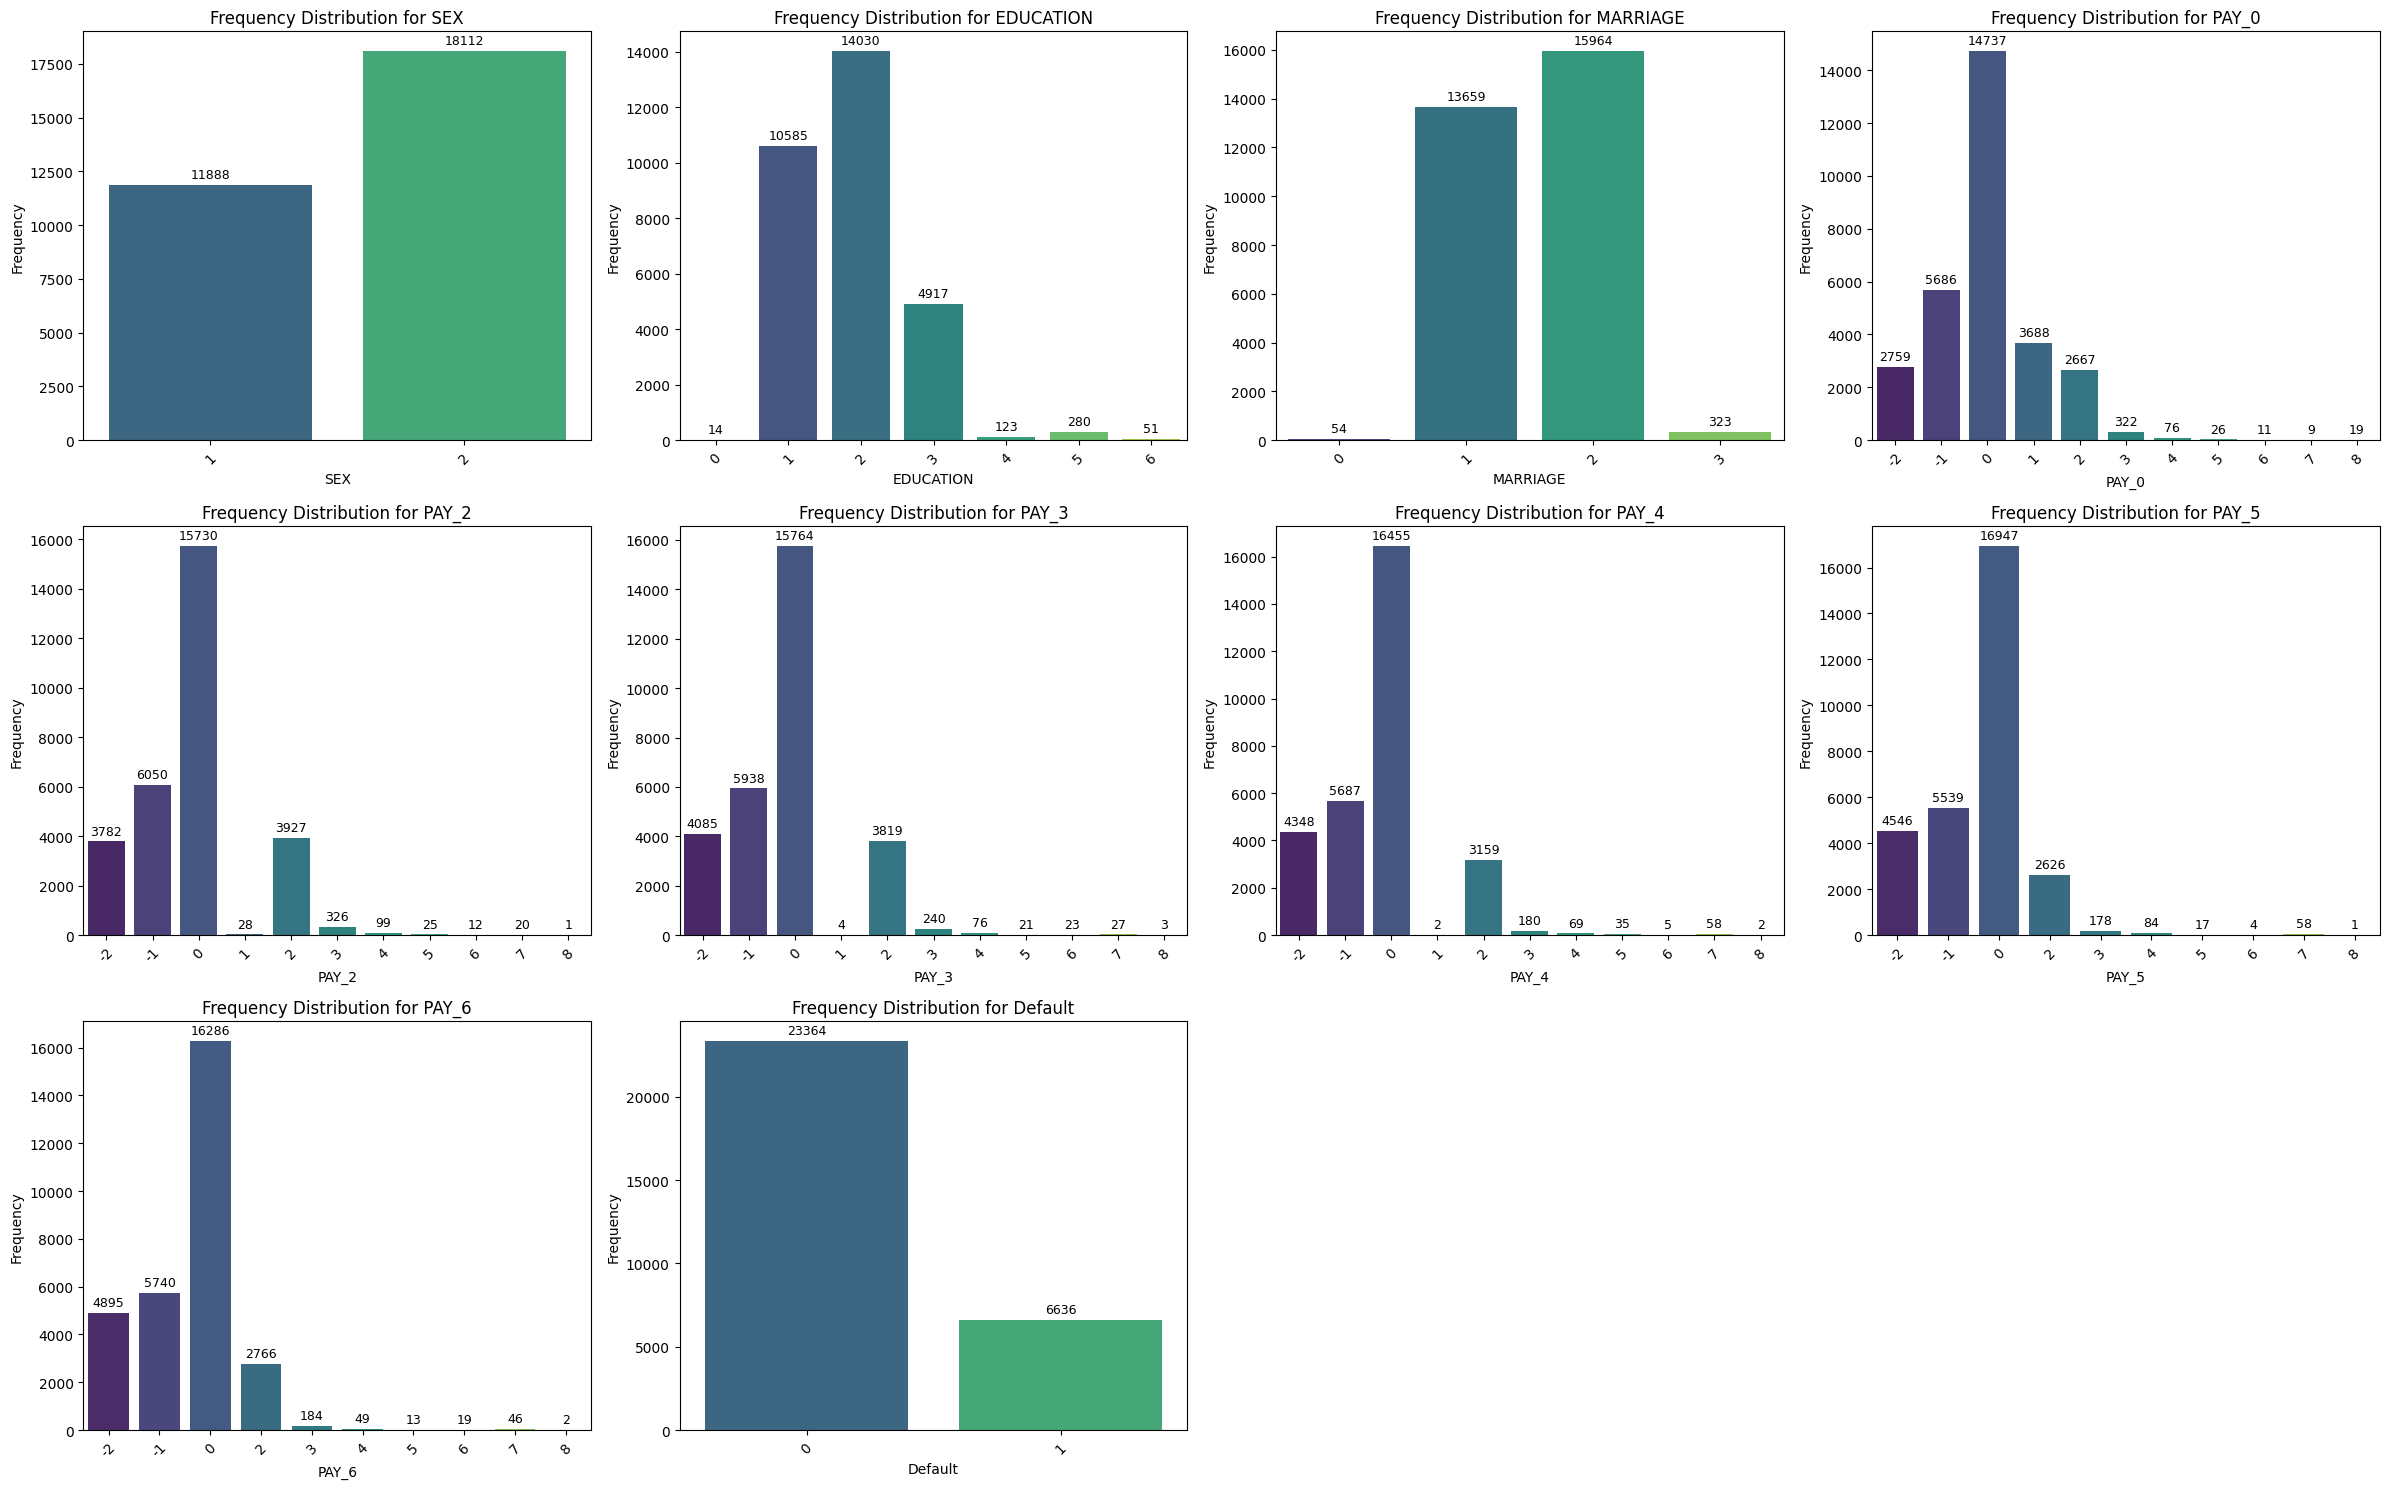

In [ ]:
# --- Dynamically Determine Grid Size ---
ncols = 4
nrows = math.ceil(len(cat_cols) / ncols)

# Create the subplots
fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 5 * nrows))
axes = axes.flatten() # Flatten to easily loop through each subplot

# Loop through categorical columns and plot in the respective subplot
for i, col_name in enumerate(cat_cols):
    ax = axes[i] # Select the subplot for the current column
    
    # Use value_counts for a more direct approach with pandas
    value_counts = df[col_name].value_counts().sort_index()
    
    # Plotting the bar plot
    sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis", ax=ax)
    ax.set_title(f"Frequency Distribution for {col_name}", fontsize=12)
    ax.set_xlabel(col_name)
    ax.set_ylabel('Frequency')
    ax.tick_params(axis='x', rotation=45)

    # Add text labels on top of each bar
    for patch in ax.patches:
        height = patch.get_height()
        ax.text(patch.get_x() + patch.get_width() / 2.,
                height + 0.01 * value_counts.values.max(), # Position label slightly above the bar
                f'{int(height)}',
                ha='center',
                va='bottom',
                fontsize=9)

# --- Clean Up Unused Subplots ---
for i in range(len(cat_cols), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

#### One hot encoding for categorical features

In [41]:
# --- One-Hot Encode Categorical Features ---
cat_cols = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
numeric_cols = [col for col in df.columns if col not in cat_cols + ['ID', 'Default']]


# Apply one-hot encoding
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)
df = df_encoded.copy()
original = df_encoded.copy()  # Keep a copy of the original encoded dataframe

display(df.info())
df.columns, df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 84 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           30000 non-null  int64  
 1   LIMIT_BAL    30000 non-null  float64
 2   AGE          30000 non-null  int64  
 3   BILL_AMT1    30000 non-null  float64
 4   BILL_AMT2    30000 non-null  float64
 5   BILL_AMT3    30000 non-null  float64
 6   BILL_AMT4    30000 non-null  float64
 7   BILL_AMT5    30000 non-null  float64
 8   BILL_AMT6    30000 non-null  float64
 9   PAY_AMT1     30000 non-null  float64
 10  PAY_AMT2     30000 non-null  float64
 11  PAY_AMT3     30000 non-null  float64
 12  PAY_AMT4     30000 non-null  float64
 13  PAY_AMT5     30000 non-null  float64
 14  PAY_AMT6     30000 non-null  float64
 15  Default      30000 non-null  int64  
 16  SEX_2        30000 non-null  bool   
 17  EDUCATION_1  30000 non-null  bool   
 18  EDUCATION_2  30000 non-null  bool   
 19  EDUC

None

(Index(['ID', 'LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
        'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
        'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'Default', 'SEX_2',
        'EDUCATION_1', 'EDUCATION_2', 'EDUCATION_3', 'EDUCATION_4',
        'EDUCATION_5', 'EDUCATION_6', 'MARRIAGE_1', 'MARRIAGE_2', 'MARRIAGE_3',
        'PAY_0_-1', 'PAY_0_0', 'PAY_0_1', 'PAY_0_2', 'PAY_0_3', 'PAY_0_4',
        'PAY_0_5', 'PAY_0_6', 'PAY_0_7', 'PAY_0_8', 'PAY_2_-1', 'PAY_2_0',
        'PAY_2_1', 'PAY_2_2', 'PAY_2_3', 'PAY_2_4', 'PAY_2_5', 'PAY_2_6',
        'PAY_2_7', 'PAY_2_8', 'PAY_3_-1', 'PAY_3_0', 'PAY_3_1', 'PAY_3_2',
        'PAY_3_3', 'PAY_3_4', 'PAY_3_5', 'PAY_3_6', 'PAY_3_7', 'PAY_3_8',
        'PAY_4_-1', 'PAY_4_0', 'PAY_4_1', 'PAY_4_2', 'PAY_4_3', 'PAY_4_4',
        'PAY_4_5', 'PAY_4_6', 'PAY_4_7', 'PAY_4_8', 'PAY_5_-1', 'PAY_5_0',
        'PAY_5_2', 'PAY_5_3', 'PAY_5_4', 'PAY_5_5', 'PAY_5_6', 'PAY_5_7',
        'PAY_5_8', 'PAY_6_-1', 'PAY

### Artificially introducing MAR missing values

In [60]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

df.drop(columns=["ID"], inplace=True, errors="ignore")
original.drop(columns=["ID"], inplace=True, errors="ignore")

# Choose 2–3 numeric columns for missingness
missing_cols = [c for c in ["AGE", "BILL_AMT1", "PAY_AMT1"] if c in numeric_cols][:3]
print("Columns selected for MAR missingness:", missing_cols)


# Introduce MAR missingness (~8% on average)
frac_missing = 0.05
cond_col = "LIMIT_BAL" if "LIMIT_BAL" in df.columns else num_cols[0]

def introduce_mar(series, cond_series, frac, random_state=RANDOM_STATE):
    n = len(series)
    q = pd.qcut(cond_series.rank(method='first'), 4, labels=False)
    probs = 0.02 + (q / q.max()) * (frac * 2)  # slightly increasing prob by quantile
    rng = np.random.RandomState(random_state)
    mask = rng.rand(n) < probs
    s = series.copy()
    s[mask] = np.nan
    return s, mask.sum()

df_with_missing = df.copy()
for c in missing_cols:
    s_new, nmiss = introduce_mar(df_with_missing[c], df_with_missing[cond_col], frac_missing)
    df_with_missing[c] = s_new
    print(f"{c}: Introduced {nmiss} missing values ({nmiss/len(df):.2%})")

print("\nMissingness summary:")
print(df_with_missing[missing_cols].isna().mean())

Columns selected for MAR missingness: ['AGE', 'BILL_AMT1', 'PAY_AMT1']
AGE: Introduced 2118 missing values (7.06%)
BILL_AMT1: Introduced 2118 missing values (7.06%)
PAY_AMT1: Introduced 2118 missing values (7.06%)

Missingness summary:
AGE         0.07
BILL_AMT1   0.07
PAY_AMT1    0.07
dtype: float64


#### Null checks after MAR

In [61]:
df_with_missing.isnull().sum()

LIMIT_BAL       0
AGE          2118
BILL_AMT1    2118
BILL_AMT2       0
BILL_AMT3       0
             ... 
PAY_6_4         0
PAY_6_5         0
PAY_6_6         0
PAY_6_7         0
PAY_6_8         0
Length: 83, dtype: int64

#### Distribution difference of `original` and `dataset with missing` entries

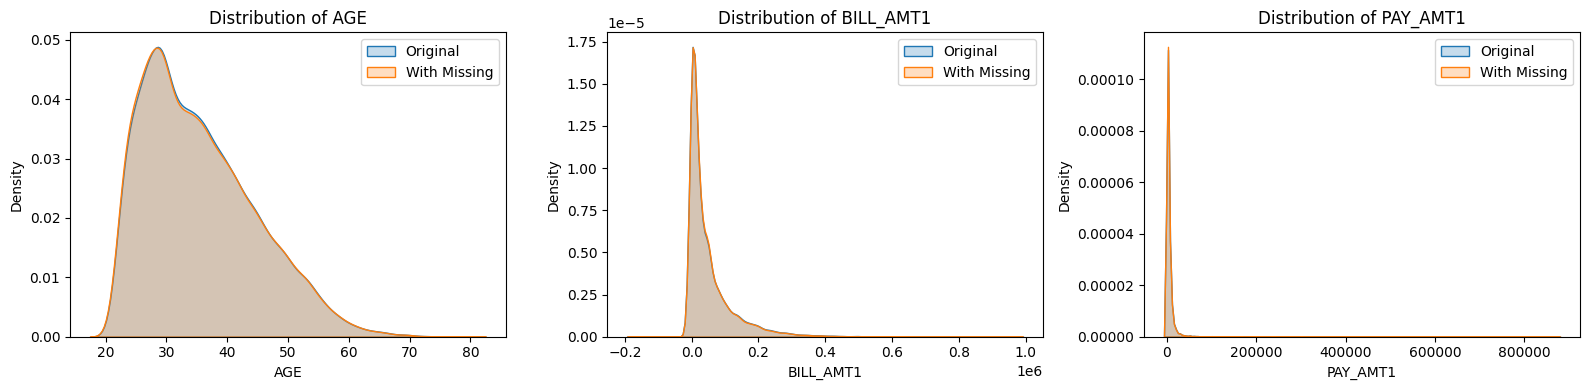

In [62]:
fig, axes = plt.subplots(1, len(missing_cols), figsize=(16, 4))
for i, col in enumerate(missing_cols):
    sns.kdeplot(df[col], ax=axes[i], label="Original", fill=True)
    sns.kdeplot(df_with_missing[col].dropna(), ax=axes[i], label="With Missing", fill=True)
    axes[i].set_title(f"Distribution of {col}")
    axes[i].legend()
plt.tight_layout()
plt.show()

#### Copy created of dataset with missing entries into `Dataset_A`, `Dataset_B`, `Dataset_C`

In [82]:
Dataset_A = df_with_missing.copy()  # For Median Imputation
Dataset_B = df_with_missing.copy() # For Linear Regression Imputation
Dataset_C = df_with_missing.copy() # For Non-Linear Regression Imputation

## 2. Imputation Strategy 1: Simple Imputation (Baseline)

- Create a clean dataset copy (Dataset A). 
- For each column with missing values, fill the missing values with the median of 
that column. Explain why the median is often preferred over the mean for 
imputation. 

In [83]:
Dataset_A = df_with_missing.copy()  # For Median Imputation
median_imputer = SimpleImputer(strategy="median")
Dataset_A[Dataset_A.columns] = median_imputer.fit_transform(Dataset_A)


print("Missing values after median imputation:")
print(Dataset_A[missing_cols].isna().sum())

Missing values after median imputation:
AGE          0
BILL_AMT1    0
PAY_AMT1     0
dtype: int64


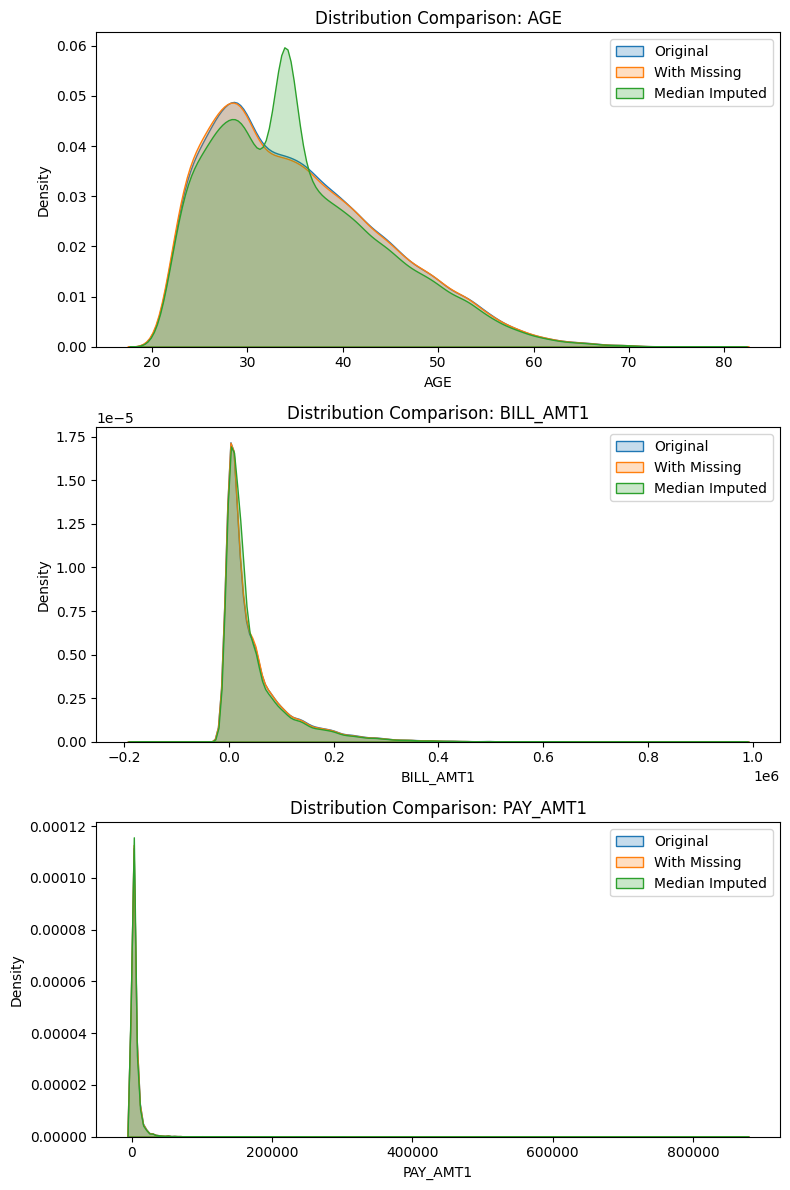

In [84]:
fig, axes = plt.subplots(len(missing_cols), 1, figsize=(8, 12))
for i, col in enumerate(missing_cols):
    sns.kdeplot(df[col], ax=axes[i], label="Original", fill=True)
    sns.kdeplot(df_with_missing[col].dropna(), ax=axes[i], label="With Missing", fill=True)
    sns.kdeplot(Dataset_A[col], ax=axes[i], label="Median Imputed", fill=True)
    axes[i].set_title(f"Distribution Comparison: {col}")
    axes[i].legend()
plt.tight_layout()
plt.show()

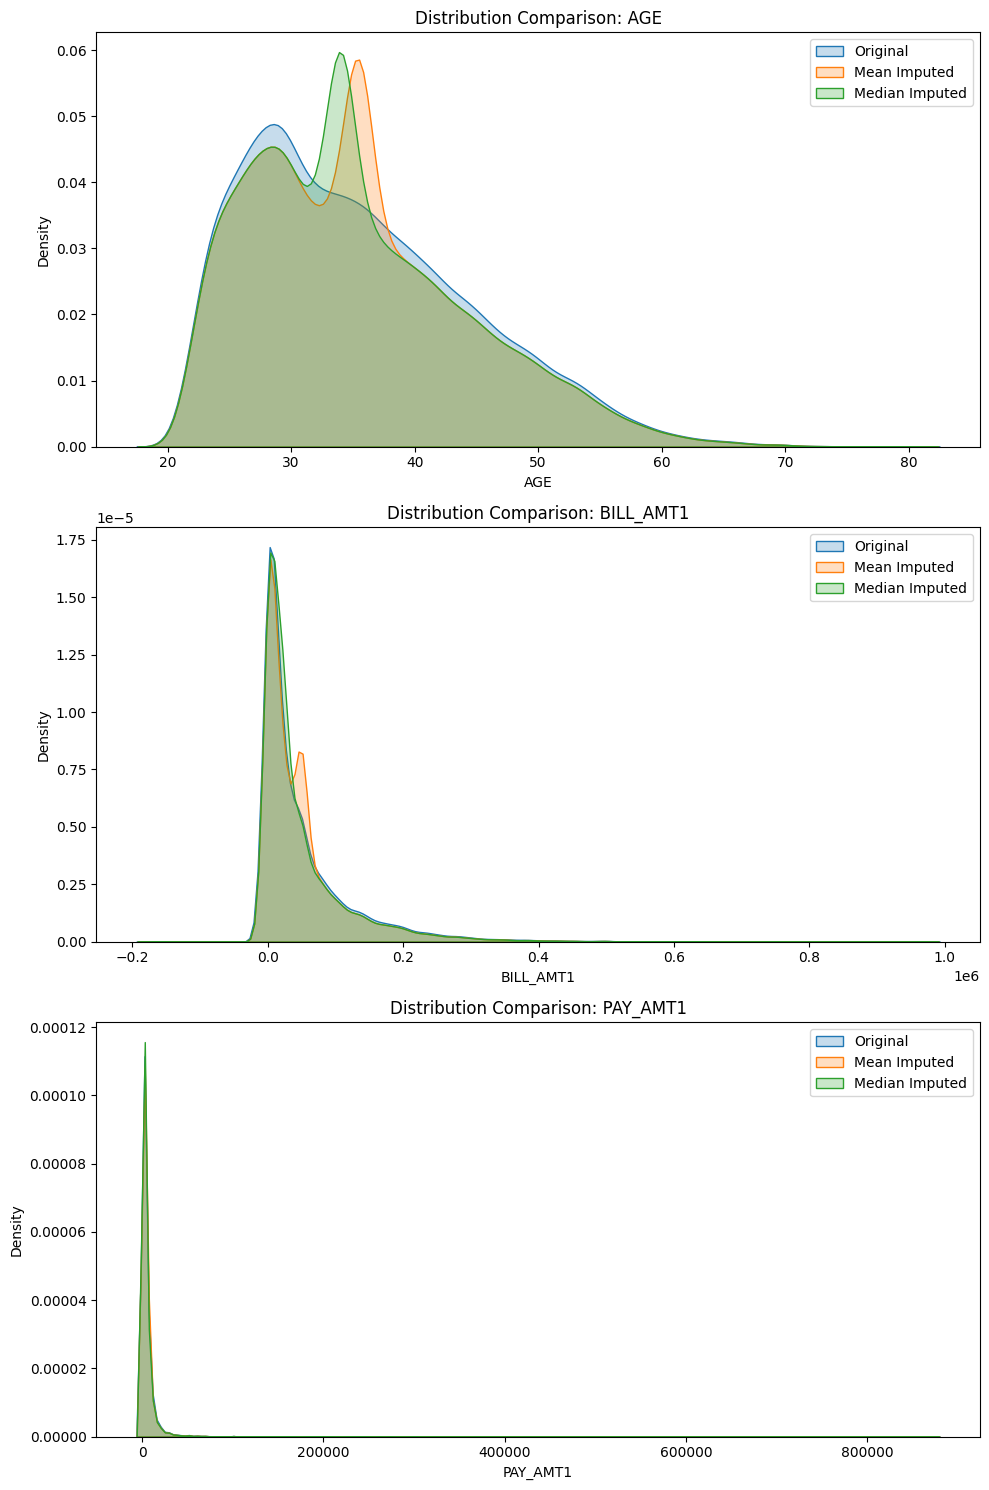

In [85]:
mean_imputer = SimpleImputer(strategy="mean")
median_imputer = SimpleImputer(strategy="median")

df_mean = df_with_missing.copy()

df_mean[df_mean.columns] = mean_imputer.fit_transform(df_mean)
df_median = Dataset_A.copy()


fig, axes = plt.subplots(len(missing_cols), 1, figsize=(10, 5*len(missing_cols)))
for i, col in enumerate(missing_cols):
    sns.kdeplot(df[col], ax=axes[i], label="Original", fill=True)
    # sns.kdeplot(df_with_missing[col], ax=axes[i], label="With missing", fill=True)
    sns.kdeplot(df_mean[col], ax=axes[i], label="Mean Imputed", fill=True)
    sns.kdeplot(df_median[col], ax=axes[i], label="Median Imputed", fill=True)
    # axes[i].set_xscale('log')
    axes[i].set_title(f"Distribution Comparison: {col}")
    axes[i].legend()
plt.tight_layout()
plt.show()

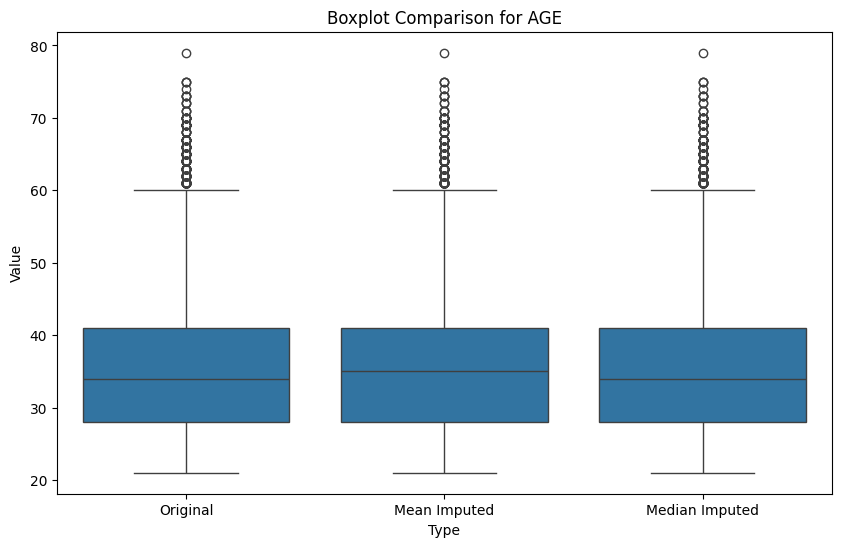

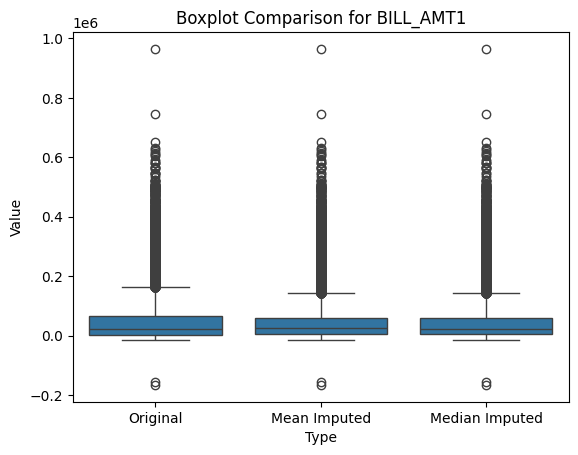

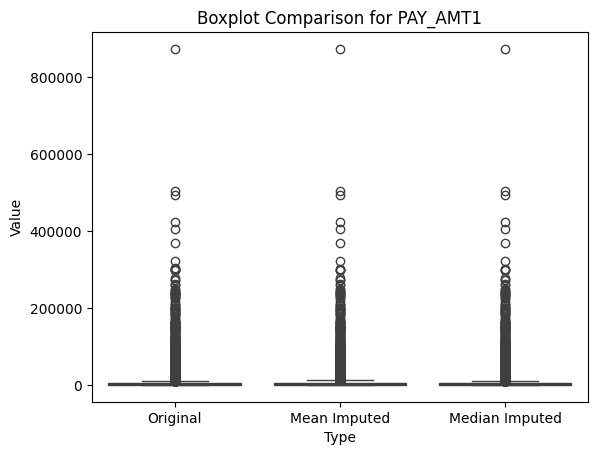

In [86]:
plt.figure(figsize=(10, 6))
for col in missing_cols:
    melted = pd.DataFrame({
        'Original': df[col],
        'Mean Imputed': df_mean[col],
        'Median Imputed': df_median[col]
    }).melt(var_name='Type', value_name='Value')
    sns.boxplot(x='Type', y='Value', data=melted)
    plt.title(f"Boxplot Comparison for {col}")
    plt.show()

In [87]:
summary_list = []
for col in missing_cols:
    orig_stats = df[col].describe()[['mean','50%','std']]
    mean_stats = df_mean[col].describe()[['mean','50%','std']]
    median_stats = df_median[col].describe()[['mean','50%','std']]
    summary_list.append({
        'Column': col,
        'Original Mean': orig_stats['mean'],
        'Mean-Imputed Mean': mean_stats['mean'],
        'Median-Imputed Mean': median_stats['mean'],
        'Original Median': orig_stats['50%'],
        'Mean-Imputed Median': mean_stats['50%'],
        'Median-Imputed Median': median_stats['50%'],
        'Original Std': orig_stats['std'],
        'Mean-Imputed Std': mean_stats['std'],
        'Median-Imputed Std': median_stats['std'],
    })

summary_df = pd.DataFrame(summary_list)
pd.options.display.float_format = "{:.2f}".format
summary_df


,Column,Original Mean,Mean-Imputed Mean,Median-Imputed Mean,Original Median,Mean-Imputed Median,Median-Imputed Median,Original Std,Mean-Imputed Std,Median-Imputed Std
0,AGE,35.49,35.42,35.32,34.00,35.00,34.00,9.22,8.92,8.92
1,BILL_AMT1,51223.33,50394.64,48419.81,22381.50,27178.50,22422.50,73635.86,69659.13,70026.68
2,PAY_AMT1,5663.58,5548.86,5305.33,2100.00,2491.00,2099.50,16563.28,15781.13,15805.84


## 3.  Imputation Strategy 2: Regression Imputation (Linear): 
- Create a second clean dataset copy (Dataset B). 
- For a single column (your choice) with missing values, use a Linear Regression model to predict the missing values based on all other non-missing features. 
- Explain the underlying assumption of this method (Missing At Random). 

Column chosen for regression imputation: AGE
Shape after regression imputation: (30000, 83)
Missing values remaining in AGE: 0


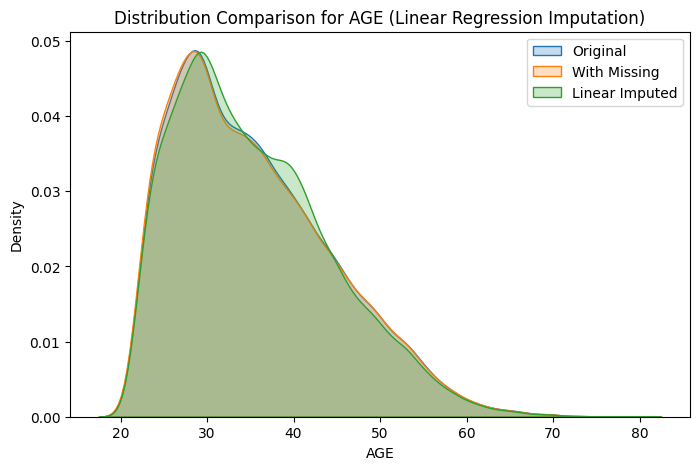

In [88]:
Dataset_B = df_with_missing.copy() # For Linear Regression Imputation

impute_col = missing_cols[0] # Age
print(f"Column chosen for regression imputation: {impute_col}")

# Fill other missing columns with median first (to avoid NaNs in predictors)
other_missing_cols = [c for c in missing_cols if c != impute_col]
if other_missing_cols:
    Dataset_B[other_missing_cols] = SimpleImputer(strategy="median").fit_transform(Dataset_B[other_missing_cols])

train_df = Dataset_B[Dataset_B[impute_col].notnull()]
# Data to predict: rows where impute_col is missing
missing_df = Dataset_B[Dataset_B[impute_col].isnull()]

# Define features (X) and target (y)
features = [col for col in train_df.columns if col != impute_col]
X_train = train_df[features]
y_train = train_df[impute_col]
X_predict = missing_df[features]

lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict missing values
if not missing_df.empty:
    X_missing = missing_df[features]
    y_pred_missing = lr.predict(X_missing)
    Dataset_B.loc[Dataset_B[impute_col].isna(), impute_col] = y_pred_missing

# Final median imputation to catch any remaining NAs
Dataset_B[Dataset_B.columns] = SimpleImputer(strategy="median").fit_transform(Dataset_B)

print("Shape after regression imputation:", Dataset_B.shape)
print(f"Missing values remaining in {impute_col}: {Dataset_B[impute_col].isna().sum()}")

plt.figure(figsize=(8,5))
sns.kdeplot(df[impute_col], label="Original", fill=True)
sns.kdeplot(df_with_missing[impute_col].dropna(), label="With Missing", fill=True)
sns.kdeplot(Dataset_B[impute_col], label="Linear Imputed", fill=True)
plt.title(f"Distribution Comparison for {impute_col} (Linear Regression Imputation)")
plt.legend()
plt.show()



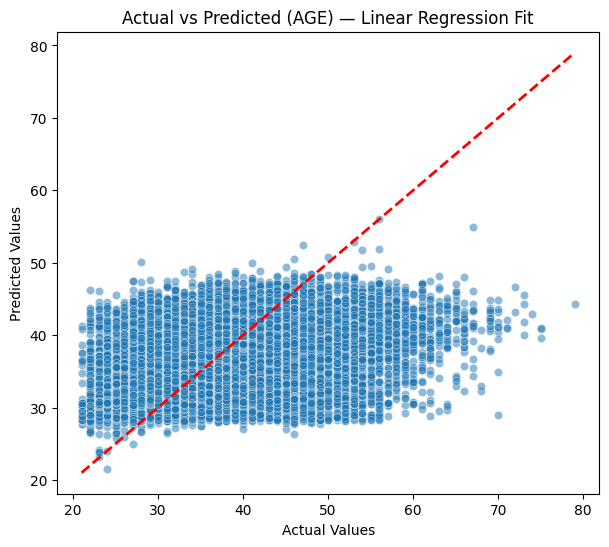

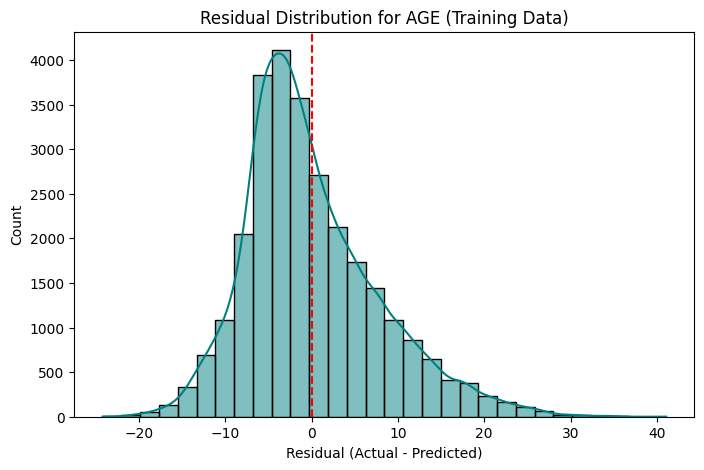

In [89]:

y_train_pred = lr.predict(X_train)

# Compute residuals (errors)
residuals = y_train - y_train_pred

# Scatter plot of actual vs predicted values
plt.figure(figsize=(7,6))
sns.scatterplot(x=y_train, y=y_train_pred, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs Predicted ({impute_col}) — Linear Regression Fit")
plt.show()

# Residual (error) distribution
plt.figure(figsize=(8,5))
sns.histplot(residuals, kde=True, bins=30, color='teal')
plt.axvline(0, color='red', linestyle='--')
plt.title(f"Residual Distribution for {impute_col} (Training Data)")
plt.xlabel("Residual (Actual - Predicted)")
plt.show()

## 4.  Imputation Strategy 3: Regression Imputation (Non-Linear) [6]: 
- Create a third clean dataset copy (Dataset C). 
- For the same column as in Strategy 2, use a non-linear regression model (e.g., K-Nearest Neighbors Regression or Decision Tree Regression) to predict the missing values.

,LIMIT_BAL,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Default
count,2118.00,2118.00,2118.00,2118.00,2118.00,2118.00,2118.00,2118.00,2118.00,2118.00,2118.00,2118.00,2118.00,2118.00
mean,230736.54,22422.50,58809.53,56736.09,52601.61,49971.37,47981.99,2099.50,8019.85,6804.72,6733.88,6651.75,7036.04,0.18
std,129603.24,0.00,86287.10,83759.56,78424.00,73813.14,72158.66,0.00,23672.43,19406.32,18847.31,19783.65,22512.97,0.38
min,10000.00,22422.50,-33350.00,-34041.00,-34503.00,-61372.00,-339603.00,2099.50,0.00,0.00,0.00,0.00,0.00,0.00
25%,140000.00,22422.50,1676.25,1530.25,1410.00,1052.75,800.50,2099.50,772.00,390.00,301.50,309.00,150.00,0.00
50%,210000.00,22422.50,18459.00,18608.50,17169.50,16407.50,14008.00,2099.50,2548.50,2200.00,2000.00,2122.50,2000.00,0.00
75%,310000.00,22422.50,81627.50,78519.00,71673.00,70972.75,69222.00,2099.50,6722.75,6029.75,5500.00,5293.75,5299.50,0.00
max,740000.00,22422.50,535509.00,548020.00,542653.00,483003.00,473944.00,2099.50,358689.00,344261.00,330982.00,300000.00,403500.00,1.00


Missing values remaining in AGE: 0


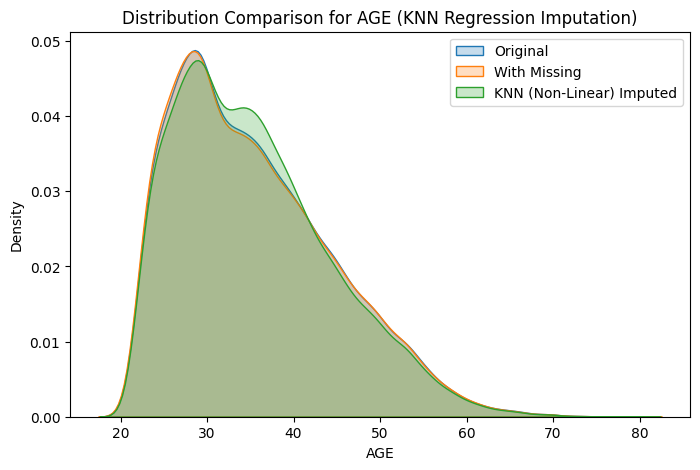

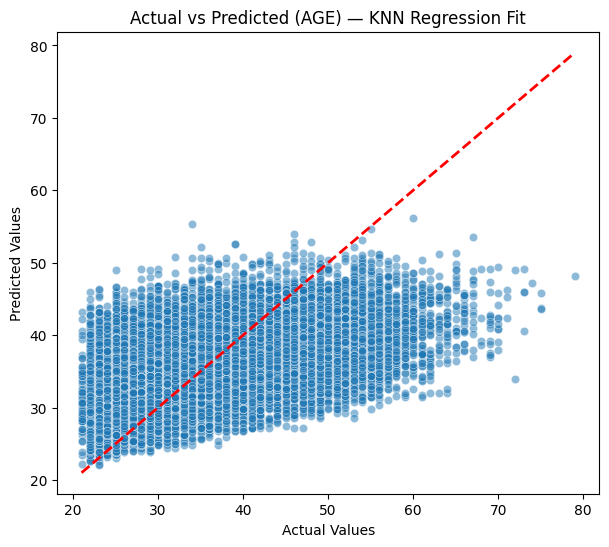

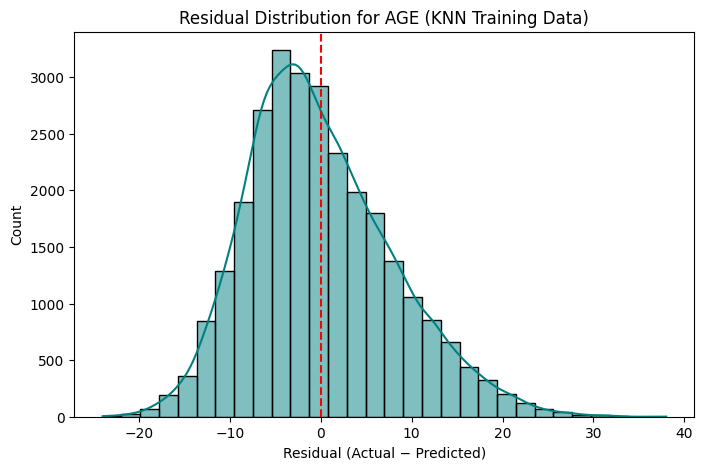

In [92]:
Dataset_C = df_with_missing.copy() # For Non-Linear Regression Imputation

# Fill other missing columns with median first
other_missing_cols = [c for c in missing_cols if c != impute_col]
if other_missing_cols:
    Dataset_C[other_missing_cols] = SimpleImputer(strategy="median").fit_transform(Dataset_C[other_missing_cols])


# Split data into known and missing target
df_train_c = Dataset_C[Dataset_C[impute_col].notnull()]
df_missing_c = Dataset_C[Dataset_C[impute_col].isnull()]


X_train_c = df_train_c[features]
y_train_c = df_train_c[impute_col]

# Fit KNN Regressor (non-linear)
knn_reg = KNeighborsRegressor(n_neighbors=5)
knn_reg.fit(X_train_c, y_train_c)


# Predict missing values
if not df_missing_c.empty:
    X_missing_c = df_missing_c[features]
    display(X_missing_c.describe())
    y_pred_knn = knn_reg.predict(X_missing_c)
    Dataset_C.loc[Dataset_C[impute_col].isna(), impute_col] = y_pred_knn
Dataset_C[Dataset_C.columns] = SimpleImputer(strategy="median").fit_transform(Dataset_C)

print(f"Missing values remaining in {impute_col}: {Dataset_C[impute_col].isna().sum()}")

# %%
plt.figure(figsize=(8,5))
sns.kdeplot(df[impute_col], label="Original", fill=True)
sns.kdeplot(df_with_missing[impute_col].dropna(), label="With Missing", fill=True)
sns.kdeplot(Dataset_C[impute_col], label="KNN (Non-Linear) Imputed", fill=True)
plt.title(f"Distribution Comparison for {impute_col} (KNN Regression Imputation)")
plt.legend()
plt.show()

# Predict on training data to assess fit
y_train_pred_c = knn_reg.predict(X_train_c)
residuals_c = y_train_c - y_train_pred_c

# Scatter plot of actual vs predicted
plt.figure(figsize=(7,6))
sns.scatterplot(x=y_train_c, y=y_train_pred_c, alpha=0.5)
plt.plot([y_train_c.min(), y_train_c.max()], [y_train_c.min(), y_train_c.max()], 'r--', lw=2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs Predicted ({impute_col}) — KNN Regression Fit")
plt.show()

# Residual (error) distribution
plt.figure(figsize=(8,5))
sns.histplot(residuals_c, kde=True, bins=30, color='teal')
plt.axvline(0, color='red', linestyle='--')
plt.title(f"Residual Distribution for {impute_col} (KNN Training Data)")
plt.xlabel("Residual (Actual − Predicted)")
plt.show()

# Part B: Model Training and Performance Assessment 
### 1.  Data Split: 
For each of the three imputed datasets (A, B, C), split the data into training and testing sets. Also, create a fourth dataset (Dataset D) by simply removing all rows that contain any missing values (Listwise Deletion). Split Dataset D into training and testing sets. 


### 2.  Classifier Setup: 
Standardize the features in all four datasets (A, B, C, D) using StandardScaler. 

In [93]:
Dataset_D = df_with_missing.dropna().copy()

name = ['Dataset_A', 'Dataset_B', 'Dataset_C', 'Dataset_D', 'Original']
for n, d in zip(name, [Dataset_A, Dataset_B, Dataset_C, Dataset_D, original]):
    print(f"Nan value in {n} => {d.isnull().sum().sum()}")
print(f"Shapes -> A:{Dataset_A.shape}, B:{Dataset_B.shape}, C:{Dataset_C.shape}, D:{Dataset_D.shape}, Original:{original.shape}")


TARGET = 'Default'
print(f"Target column: {TARGET}")

# Helper function to split and scale
def split_and_scale(df_local, target_col, test_size=0.25, random_state=42):
    df_local = df_local.copy()
    X = df_local.drop(columns=[target_col])
    y = df_local[target_col]

    # Train/test split (stratified by class for balance)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )

    # Standardize numeric columns
    scaler = StandardScaler()
    num_cols = X_train.select_dtypes(include=[np.number]).columns
    X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
    X_test[num_cols] = scaler.transform(X_test[num_cols])

    return {
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test,
        "scaler": scaler,
    }

# Apply to all datasets
split_A = split_and_scale(Dataset_A, TARGET)
split_B = split_and_scale(Dataset_B, TARGET)
split_C = split_and_scale(Dataset_C, TARGET)
split_D = split_and_scale(Dataset_D, TARGET)
split_E = split_and_scale(original, TARGET)

# Verify dimensions
for name, split in zip(['A - Median', 'B - Linear', 'C - KNN', 'D - Listwise', 'E - Original'],
                       [split_A, split_B, split_C, split_D, split_E]):
    print(f"{name}: Train {split['X_train'].shape}, Test {split['X_test'].shape}")

Nan value in Dataset_A => 0
Nan value in Dataset_B => 0
Nan value in Dataset_C => 0
Nan value in Dataset_D => 0
Nan value in Original => 0
Shapes -> A:(30000, 83), B:(30000, 83), C:(30000, 83), D:(27882, 83), Original:(30000, 83)
Target column: Default
A - Median: Train (22500, 82), Test (7500, 82)
B - Linear: Train (22500, 82), Test (7500, 82)
C - KNN: Train (22500, 82), Test (7500, 82)
D - Listwise: Train (20911, 82), Test (6971, 82)
E - Original: Train (22500, 82), Test (7500, 82)


### Oversampling using CBO for balancing the moderate unbalanced target variable

In [94]:
from sklearn.cluster import KMeans

def cluster_based_oversample(X, y, minority_class=1, n_clusters=5, random_state=42):
    """
    Cluster-Based Oversampling for minority class. (Corrected Version)
    """
    # Separate minority and majority
    X_min = X[y == minority_class]
    X_maj = X[y != minority_class]
    
    # --- SAFETY CHECK ---
    # Ensure there are enough minority samples to form the requested clusters
    if X_min.shape[0] < n_clusters:
        print("Warning: Number of minority samples is less than n_clusters. Reducing n_clusters.")
        n_clusters = X_min.shape[0]
        # If still no samples, cannot proceed
        if n_clusters == 0:
            return X, y

    # Cluster minority samples
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10) # Added n_init for stability
    cluster_labels = kmeans.fit_predict(X_min)
    
    # Determine how many synthetic points are needed
    n_synthetic = int((X_maj.shape[0] - X_min.shape[0]) * 0.8)
    
    synthetic_samples = []
    rng = np.random.default_rng(random_state)
    
    while len(synthetic_samples) < n_synthetic:
        # Pick a random cluster
        cluster_idx = rng.integers(0, n_clusters)
        
        # --- FIX IS HERE ---
        # Get points in the selected cluster
        cluster_points = X_min[cluster_labels == cluster_idx]
        
        # If the cluster has fewer than 2 points, skip and try another cluster
        if len(cluster_points) < 2:
            continue
        # --- END OF FIX ---
        
        # Pick two random points in the cluster
        i1, i2 = rng.choice(len(cluster_points), size=2, replace=False)
        pt1, pt2 = cluster_points[i1], cluster_points[i2]
        
        # Generate synthetic point (interpolation)
        alpha = rng.random()
        new_point = pt1 + alpha * (pt2 - pt1)
        synthetic_samples.append(new_point)
    
    if not synthetic_samples:
        return X, y

    X_synthetic = np.array(synthetic_samples)
    y_synthetic = np.full(len(X_synthetic), minority_class)
    
    # Combine with original data
    X_resampled = np.vstack([X, X_synthetic])
    y_resampled = np.hstack([y, y_synthetic])
    
    return X_resampled, y_resampled

## 3. Model Evaluation:
Train a Logistic Regression classifier on the training set of each of the four datasets (A, B, C, D). Evaluate the performance of each model on its respective test set using a full Classification Report (Accuracy, recision, Recall, F1-score). 

===== Training and Evaluating Model for Dataset A (Median Imputation) =====
class distribution before oversampling:  (array([0., 1.]), array([17523,  4977]))
class distribution after oversampling:  (array([0., 1.]), array([17523, 17523]))
                 precision    recall  f1-score   support

Not Default (0)     0.8736    0.8225    0.8473      5841
    Default (1)     0.4818    0.5811    0.5268      1659

       accuracy                         0.7691      7500
      macro avg     0.6777    0.7018    0.6870      7500
   weighted avg     0.7869    0.7691    0.7764      7500

-----------------------------------------------------------------

===== Training and Evaluating Model for Dataset B (Linear Regression Imputation) =====
class distribution before oversampling:  (array([0., 1.]), array([17523,  4977]))
class distribution after oversampling:  (array([0., 1.]), array([17523, 17523]))
                 precision    recall  f1-score   support

Not Default (0)     0.8736    0.8223    0

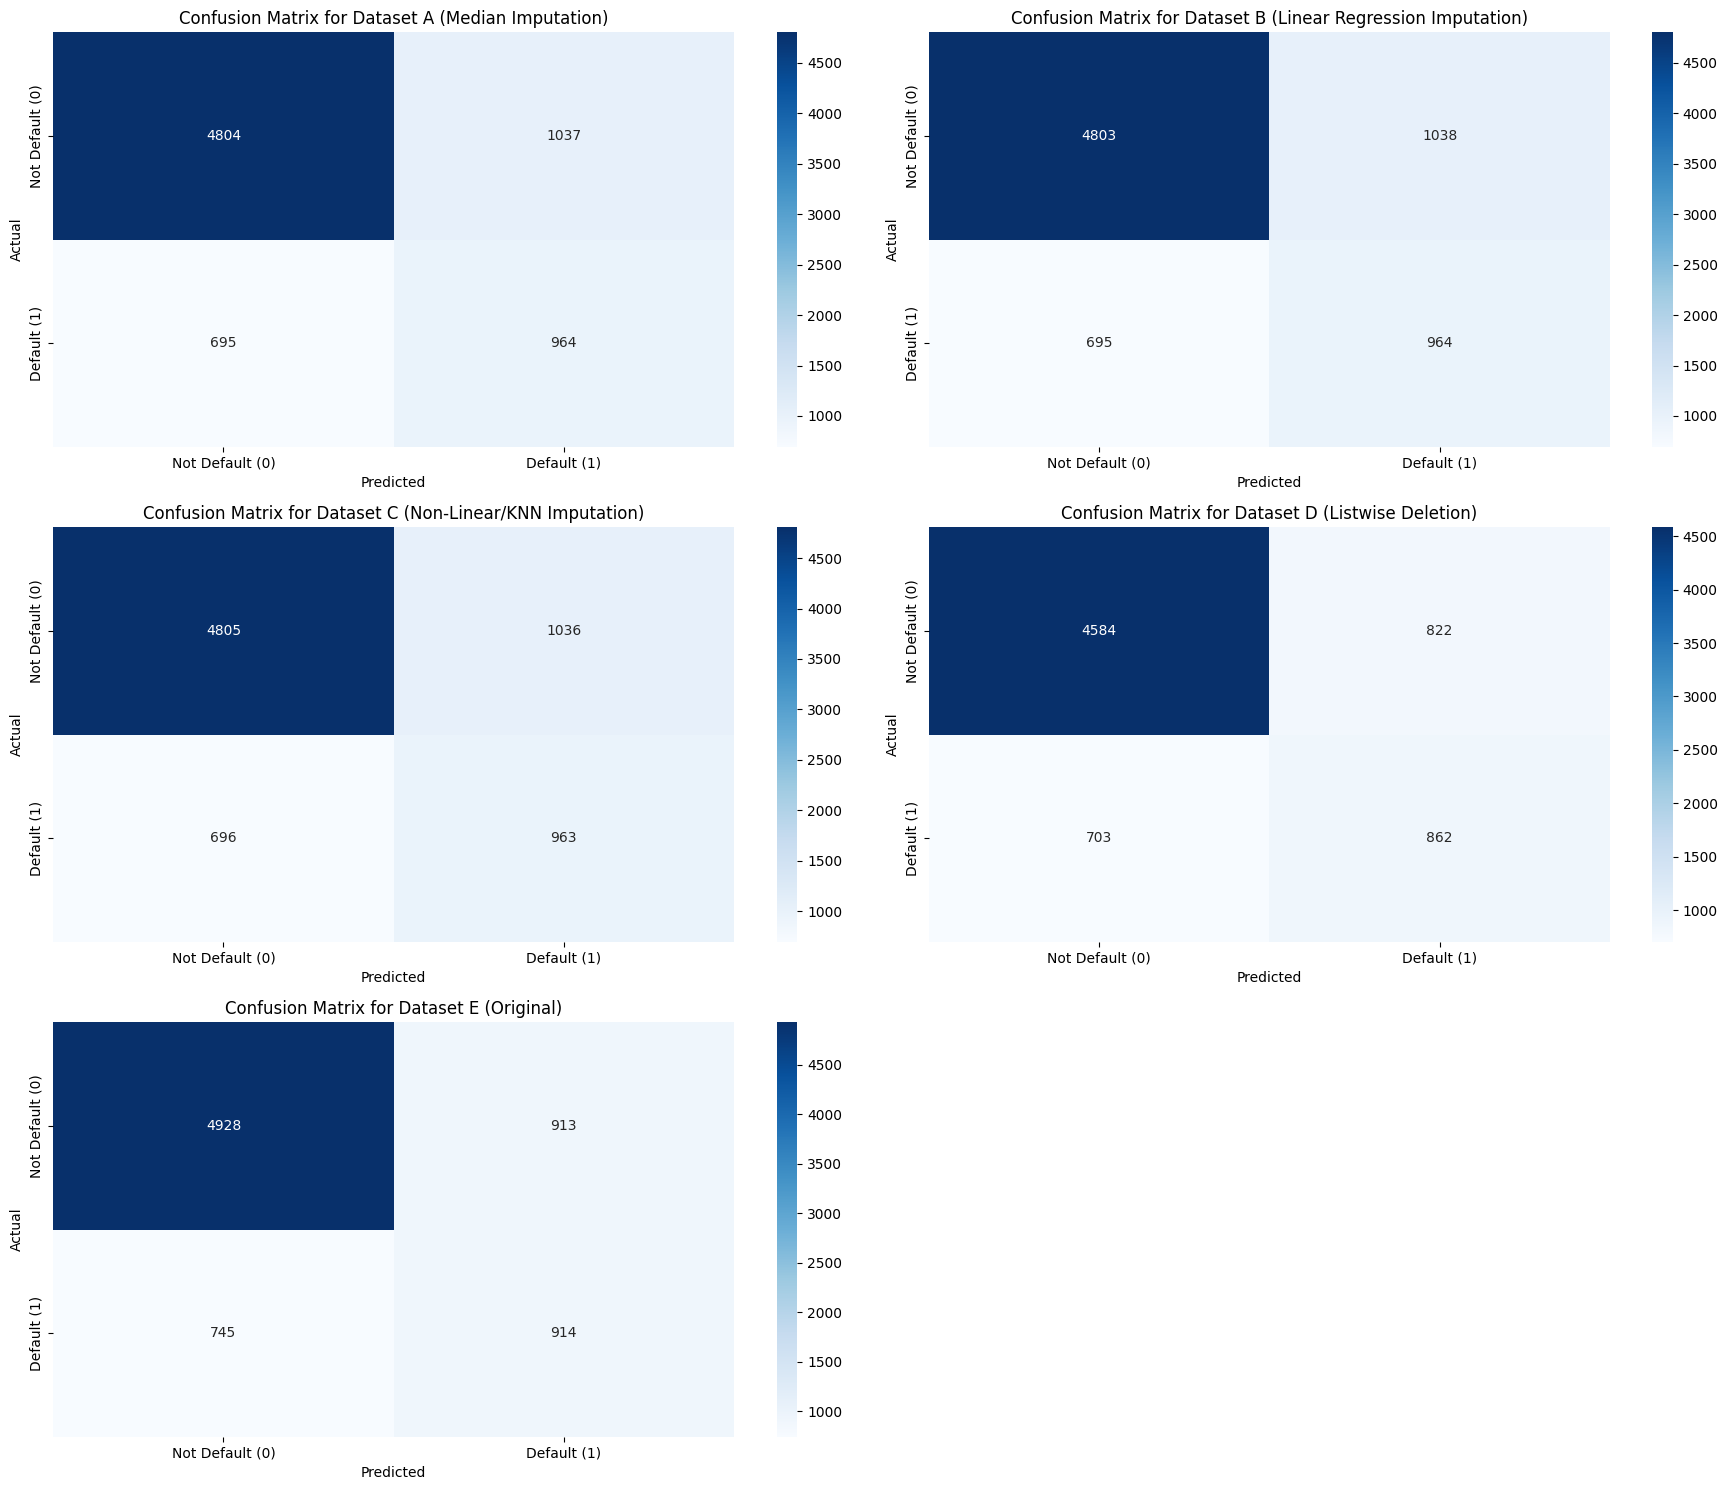

In [98]:
# --- Assume you have these variables from the previous steps (Data Split & Scaling) ---
# For Dataset A (Median Imputation)
# X_train_A, X_test_A, y_train_A, y_test_A

# For Dataset B (Linear Regression Imputation)
# X_train_B, X_test_B, y_train_B, y_test_B

# For Dataset C (Non-Linear Regression Imputation)
# X_train_C, X_test_C, y_train_C, y_test_C

# For Dataset D (Listwise Deletion)
# X_train_D, X_test_D, y_train_D, y_test_D
# ---

# Create dictionaries to hold our datasets for easy iteration
model_name = ["A (Median Imputation)", "B (Linear Regression Imputation)", "C (Non-Linear/KNN Imputation)", "D (Listwise Deletion)", "E (Original)"]
train_sets = {
    "A (Median Imputation)": (split_A['X_train'], split_A['y_train']),
    "B (Linear Regression Imputation)": (split_B['X_train'], split_B['y_train']),
    "C (Non-Linear/KNN Imputation)": (split_C['X_train'], split_C['y_train']),
    "D (Listwise Deletion)": (split_D['X_train'], split_D['y_train']),
    "E (Original)": (split_E['X_train'], split_E['y_train'])    
}

test_sets = {
    "A (Median Imputation)": (split_A['X_test'], split_A['y_test']),
    "B (Linear Regression Imputation)": (split_B['X_test'], split_B['y_test']),
    "C (Non-Linear/KNN Imputation)": (split_C['X_test'], split_C['y_test']),
    "D (Listwise Deletion)": (split_D['X_test'], split_D['y_test']),
    "E (Original)": (split_E['X_test'], split_E['y_test'])
}

# Assuming cluster_based_oversample and other dependencies are defined elsewhere

# Initialize the subplot figure (2x2)
fig, axes = plt.subplots(3, 2, figsize=(18, 15))
axes = axes.flatten()  # Flatten to easily index each subplot

results = {}
models = {}
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN, SMOTENC

for i, (name, (X_train, y_train)) in enumerate(train_sets.items()):
    print(f"===== Training and Evaluating Model for Dataset {name} =====")
    
    print('class distribution before oversampling: ', np.unique(y_train, return_counts=True))
    
    # Perform oversampling

    # In your loop, replace your custom function call with this:
    sampler = SMOTE(random_state=42)

    X_train_os, y_train_os = sampler.fit_resample(X_train, y_train)
    # X_train_os, y_train_os = cluster_based_oversample(X_train.values, y_train.values, minority_class=1, n_clusters=5, random_state=42)
    
    log_reg_model = LogisticRegression(random_state=63, max_iter=50000)
    print('class distribution after oversampling: ', np.unique(y_train_os, return_counts=True))
    
    # Train model
    log_reg_model.fit(X_train_os, y_train_os)
    
    # Predict on test set
    X_test, y_test = test_sets[name]
    y_pred = log_reg_model.predict(X_test)
    
    # Classification report
    report = classification_report(y_test, y_pred, target_names=['Not Default (0)', 'Default (1)'], output_dict=True, digits=4)
    print(classification_report(y_test, y_pred, target_names=['Not Default (0)', 'Default (1)'], digits=4))
    
    # Save metrics and model
    results[name] = {
        'Precision': report['Default (1)']['precision'],
        'Recall': report['Default (1)']['recall'],
        'F1-Score': report['Default (1)']['f1-score'],
        'Accuracy': report['accuracy']
    }
    models[name] = log_reg_model
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix in subplot
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Default (0)', 'Default (1)'],
                yticklabels=['Not Default (0)', 'Default (1)'],
                ax=axes[i])
    axes[i].set_title(f'Confusion Matrix for Dataset {name}')
    axes[i].set_ylabel('Actual')
    axes[i].set_xlabel('Predicted')
    
    print("-" * 65 + "\n")

# erase the last empty subplot if there are less than 6 models
if len(train_sets) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

# Optionally, access individual model reports outside the loop
model_A, report_A = model_name[0], results[model_name[0]]
model_B, report_B = model_name[1], results[model_name[1]]
model_C, report_C = model_name[2], results[model_name[2]]
model_D, report_D = model_name[3], results[model_name[3]]


# Part C: Comparative Analysis [20 points] 
## 1.  Results Comparison [10]: 
Create a summary table comparing the performance metrics (especially F1-score) of the four models: 
-  Model A (Median Imputation) 
-  Model B (Linear Regression Imputation) 
-  Model C (Non-Linear Regression Imputation) 
-  Model D (Listwise Deletion) 

--- Performance Summary of Classification Models ---
                                  Precision   Recall  F1-Score  Accuracy
D (Listwise Deletion)              0.511876 0.550799  0.530625  0.781237
A (Median Imputation)              0.481759 0.581073  0.526776  0.769067
B (Linear Regression Imputation)   0.481518 0.581073  0.526632  0.768933
C (Non-Linear/KNN Imputation)      0.481741 0.580470  0.526517  0.769067
E (Original)                       0.500274 0.550934  0.524383  0.778933


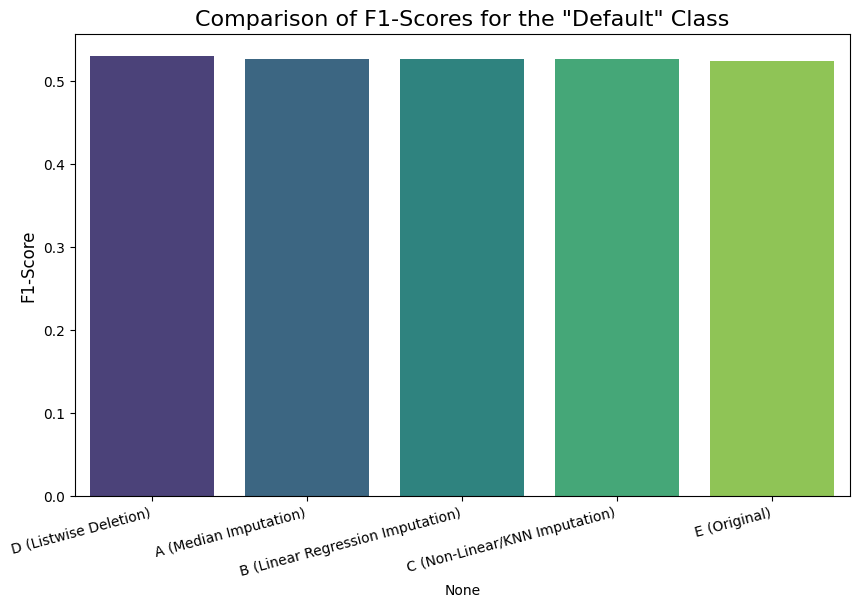

In [99]:
# --- Assume the 'results' dictionary is populated from Part B ---
# results = {
#     'A (Median Imputation)': {'Precision': 0.67, 'Recall': 0.31, 'F1-Score': 0.42, 'Accuracy': 0.81},
#     'B (Linear Regression Imputation)': {'Precision': 0.68, 'Recall': 0.32, 'F1-Score': 0.44, 'Accuracy': 0.82},
#     'C (Non-Linear/KNN Imputation)': {'Precision': 0.69, 'Recall': 0.33, 'F1-Score': 0.45, 'Accuracy': 0.82},
#     'D (Listwise Deletion)': {'Precision': 0.65, 'Recall': 0.29, 'F1-Score': 0.40, 'Accuracy': 0.80}
# }
# ---
# Convert the results dictionary to a pandas DataFrame for a clean table format
summary_df = pd.DataFrame.from_dict(results, orient='index')
# Sort the DataFrame by F1-Score in descending order to easily see the best performer
summary_df.sort_values(by='F1-Score', ascending=False, inplace=True)

# Display the summary table
print("--- Performance Summary of Classification Models ---")
# display(summary_df)
print(summary_df.to_string(float_format=lambda x: f"{x:.6f}"))

# --- Visualization of F1-Scores ---
plt.figure(figsize=(10, 6))
sns.barplot(x=summary_df.index, y=summary_df['F1-Score'], palette='viridis')
plt.title('Comparison of F1-Scores for the "Default" Class', fontsize=16)
plt.ylabel('F1-Score', fontsize=12)
plt.xticks(rotation=15, ha="right")
plt.show()

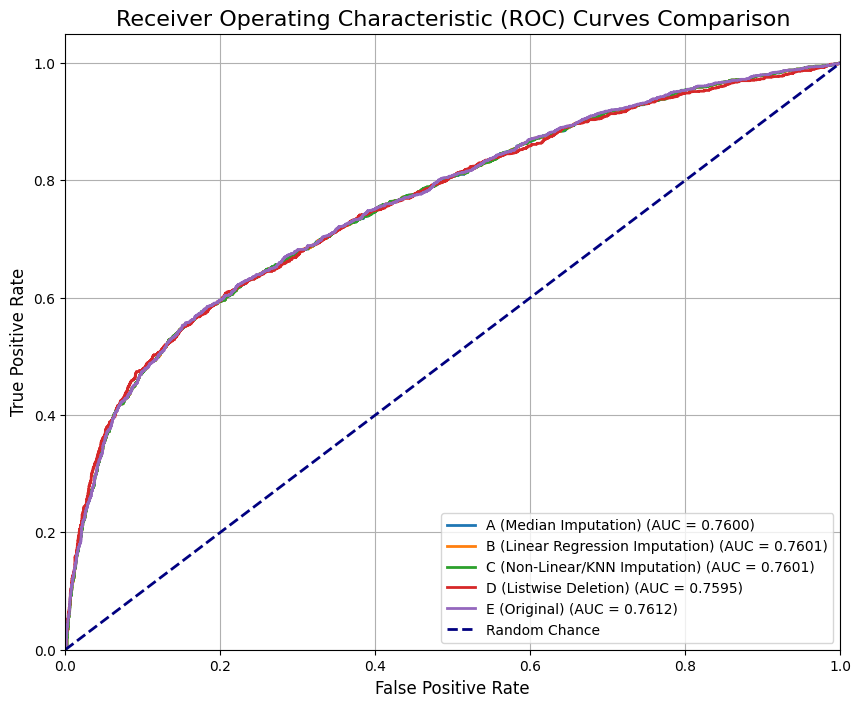

In [97]:
from sklearn.metrics import roc_curve, auc

# --- Assume the 'train_sets' and 'test_sets' dictionaries are populated ---
# Also assume the split data (split_A, split_B, etc.) is available

# Set up the plot
plt.figure(figsize=(10, 8))

# Iterate through each dataset to train, predict, and plot
for name, (X_train, y_train) in train_sets.items():
    
    # Train the Logistic Regression model (as before)
    log_reg_model = LogisticRegression(random_state=42, max_iter=1000)
    log_reg_model.fit(X_train, y_train)
    
    # Get the corresponding test set
    X_test, y_test = test_sets[name]
    
    # --- Get prediction probabilities for the positive class ('Default') ---
    # This is the key step for plotting the ROC curve
    y_pred_proba = log_reg_model.predict_proba(X_test)[:, 1]
    
    # --- Calculate ROC curve metrics ---
    # fpr: False Positive Rate
    # tpr: True Positive Rate
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    
    # --- Calculate the AUC (Area Under the Curve) score ---
    roc_auc = auc(fpr, tpr)
    
    # --- Plot the ROC curve for the current model ---
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.4f})')

# --- Finalizing the Plot ---
# Plot the "no-skill" line (a random classifier)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Chance')

# Add labels and title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curves Comparison', fontsize=16)
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## 2.  Efficacy Discussion: 
-  Discuss the trade-off between Listwise Deletion (Model D) and Imputation (Models A, B, C). Why might Model D perform poorly even if the imputed models 
perform worse? 
-  Which regression method (Linear vs. Non-Linear) performed better and why? Relate this to the assumed relationship between the imputed feature and the predictors. 
-  Conclude with a recommendation on the best strategy for handling missing data in this scenario, justifying your answer by referencing both the classification performance metrics and the conceptual implications of each method.